### Document Clustering
EXISTING script.

Since downloading a wikipedia dump, I've started my code over from scratch. `reformat.py` contains some important code to preprocess the outputted wiki dump from the wikiextractor I used.

This notebook will open a few sample JSON files and attempt to cluster them and label the clusters. This isn't hierarchical right now (only 1 level of clustering).

The

In [11]:
import json
import glob

In [12]:
CLUSTER_SIZE = 50

In [13]:
wiki_articles = []
for x in glob.glob('data/wiki*.json'):
    new_articles = json.load(open(x))['articles']
    wiki_articles += new_articles
wiki_articles[0].keys()

dict_keys(['title', 'id', 'text', 'url'])

In [14]:
for article in wiki_articles[:5]:
    for key, val in article.items():
        if key != 'text':
            print(key, ':', val)

title : Anarcho-capitalism
id : 1023
url : https://en.wikipedia.org/wiki?curid=1023
title : August 9
id : 1027
url : https://en.wikipedia.org/wiki?curid=1027
title : Aristophanes
id : 1028
url : https://en.wikipedia.org/wiki?curid=1028
title : Albert Schweitzer
id : 1029
url : https://en.wikipedia.org/wiki?curid=1029
title : Austrian School
id : 1030
url : https://en.wikipedia.org/wiki?curid=1030


Looks like my JSON conversions worked! The only problem now, is finding links that are actually related to one another so I can effectively test my clustering algorithm. I don't have my data pre-organized by topics...

We'll wee what we can visualize with T-SNE first.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.8, max_features=20000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, ngram_range=(1,3))
wiki_articles_text = [x['text'] for x in wiki_articles]
wiki_articles_titles = [x['title'] for x in wiki_articles]
tfidf_vectors = tfidf.fit_transform(wiki_articles_text)

In [25]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_vectors)


In [36]:
from sklearn.cluster import KMeans
num_clusters = 20

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_vectors)

clusters = km.labels_.tolist()

CPU times: user 2.99 s, sys: 0 ns, total: 2.99 s
Wall time: 3.02 s


In [37]:
from sklearn.externals import joblib
joblib.dump(km,  'doc_cluster{}.pkl'.format(num_clusters))

km = joblib.load('doc_cluster{}.pkl'.format(num_clusters))
clusters = km.labels_.tolist()

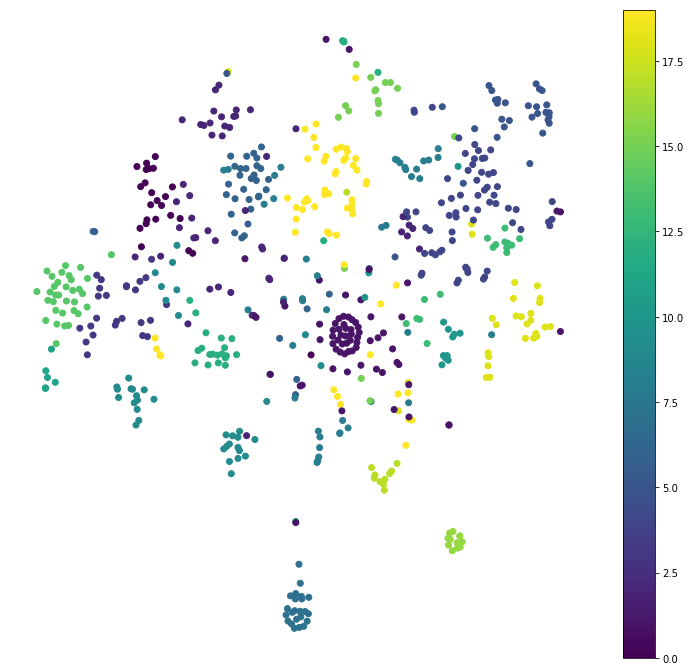

In [44]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(tfidf_vectors)
X_embedded = TSNE(n_components=2, perplexity=40, verbose=0).fit_transform(X_reduced)
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
            c=clusters, marker="o")
plt.colorbar()
plt.show()

The above is the t-SNE visualization after clustering. may want to improve clarity and try something like [this](https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b)

In [40]:
cluster_titles = dict()
for cluster, title in zip(clusters, wiki_articles_titles):
    if cluster not in cluster_titles:
        cluster_titles[cluster] = []
    cluster_titles[cluster].append(title)

In [42]:
for cluster, titles in cluster_titles.items():
    print(cluster, ', '.join(titles), '\n')

0 Anaximander, Aphrodite, Abraxas, Acropolis, Agasias, Ajax the Lesser, Ajax (mythology), Alcamenes, Aldine Press, Ambrosia, Achilles, Apollo, Alpha, Athena, Athene (disambiguation), Actaeon, Alexander, Amazons, Ambrose Traversari, Ammonius Hermiae, Anacharsis, Anaxarchus, Anastasius, Alexander the Great 

1 Northern cavefish, Abatement, Amateur, Telecommunications in Antigua and Barbuda, America's National Game, Augustin-Jean Fresnel, Atlantic (disambiguation), APL, Abydos, Álfheimr, Dodo (Alice's Adventures in Wonderland), Lory (disambiguation), Albert, Albert I, Albert III, Adder, Agapanthus africanus, Agis, Ajax, Abdominal surgery, Abduction, Casa Batlló, Arabian Prince, Ancylopoda, ASIC (disambiguation), AV, Abbotsford House, Alain Connes, Alien, Museum of Work, Analog Brothers, Advanced Chemistry, Arne Kaijser, Asociación Alumni, AM, Applied ethics, Analog signal, Atomic, Asa, Area, Telecommunications in Anguilla, Ada, Answer (law), Appellate court, Argument (disambiguation), Ani

K-means doesn't guarantee cluster sizes, but we won't worry too much about that for now. 

for `doc_cluster.pkl`: Clusters 9 and 11 clearly worked well, since August and April dates are all grouped. 10 looks pretty good, with a bunch of mathematics terminology (plus some stuff about atoms). 8 looks to be about famous people, 7 is a bit of a mess. Let's call it miscellaneous stuff. 6 is another group of historical people. 5 is... plants/flowers/animals! 4 is another of miscellaneous stuff.. 3 looks like geographical things, 2 is mostly people, 1 is religious things, and 0 looks like greek gods and whatnot. 

for `doc_cluster20.pkl`: 20 clusters definitely improved things a bit. The number of clusters used will be something to experiment with. Maybe I can define some kind of metric later on to show how "good" each num_cluster param is. Once again we have groups of greek mythology, people, august, april, math, and more. 


This is really neat. But the challenge now is to actually generate labels for each cluster myself. [this](https://nlp.stanford.edu/IR-book/html/htmledition/cluster-labeling-1.html) looks like a good reference.